In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta

In [4]:
import sys, inspect

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
for classes_found in Base.classes:
    print (classes_found)

<class 'sqlalchemy.ext.automap.measurement'>
<class 'sqlalchemy.ext.automap.station'>


In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import Session
session = Session(bind=engine)

# Exploratory Climate Analysis

In [11]:
measurement_df = pd.read_sql("SELECT * FROM measurement", engine)
measurement_df.dropna(how='any', inplace=True)
measurement_df['date'].max()

'2017-08-23'

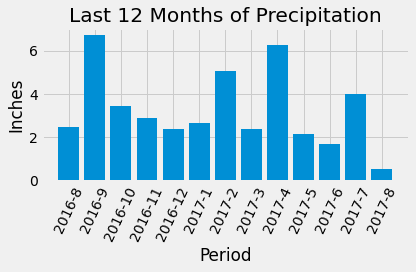

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
measurement_df = pd.read_sql("SELECT * FROM measurement", engine)

measurement_df.dropna(how='any', inplace=True)

measurement_df['year'] = pd.DatetimeIndex(measurement_df['date']).year.astype(str)
measurement_df['month'] = pd.DatetimeIndex(measurement_df['date']).month.astype(str)
measurement_df['yr_mth'] = measurement_df['year'] + "-" + measurement_df['month']


measure_p12mth = measurement_df.loc[measurement_df['date'] >= '2016-08-23']

measure_p12mth = measurement_df.loc[measurement_df['date'] >= '2016-08-23'].sort_values(by='id')
measure_p12mth.groupby(by=['yr_mth'], sort=False).sum()


plt.bar(measure_p12mth['yr_mth'],measure_p12mth['prcp'])
plt.xticks(rotation=65)

plt.title('Last 12 Months of Precipitation')
plt.xlabel('Period')
plt.ylabel('Inches')

plt.tight_layout()
plt.savefig("Images/Last_12_Month_of_Precipitation.png")
plt.show()

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
climate_measure = engine.execute("SELECT * FROM measurement")

climate_table =[]

climate_measure_headers = climate_measure.keys()

for cl in climate_measure:
    if cl[2] >= '2016-08-23':
        climate_table.append(
            {
                'date': cl[2],
                'prcp': cl[3]
            }
        )

# Save the query results as a Pandas DataFrame and set the index to the date column
climate_table_df = pd.DataFrame(climate_table)
climate_table_df.set_index('date', inplace = True)
climate_table_df.dropna(how='any', inplace = True)

# Sort the dataframe by date
climate_table_df.sort_index(inplace=True)
climate_table_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


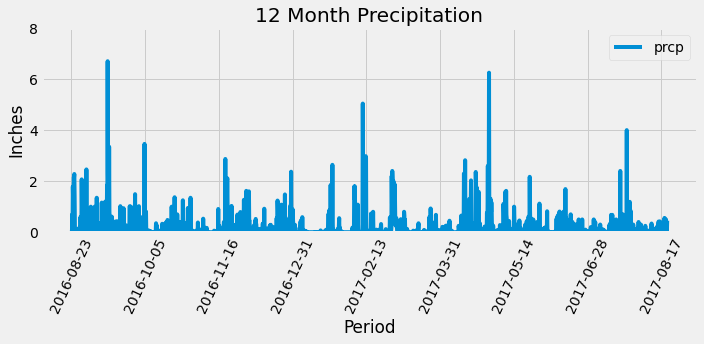

In [46]:
# climate_table_df.plot(kind="bar", figsize=(20,3))
climate_table_df.plot(figsize=(10,5),ylim=(0,8))
plt.xticks(rotation=65)
plt.title('12 Month Precipitation')
plt.xlabel('Period')
plt.ylabel('Inches')

plt.tight_layout()
plt.savefig("Images/12_Month_Precipitation.png")
plt.show()

In [34]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measure_p12mth_st = measure_p12mth[['station','prcp']]
measure_12mth_stat = measure_p12mth_st.rename(columns={'prcp': 'Precipitation'})
measure_12mth_stat.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [35]:
# Design a query to show how many stations are available in this dataset?
no_stations = pd.Series(measurement_df['station'].unique())
no_stations

0    USC00519397
1    USC00513117
2    USC00514830
3    USC00517948
4    USC00518838
5    USC00519523
6    USC00519281
7    USC00511918
8    USC00516128
dtype: object

In [36]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = pd.Series(measurement_df['station'].value_counts())
active_stations

USC00519281    2772
USC00513117    2696
USC00519397    2685
USC00519523    2572
USC00516128    2484
USC00514830    1937
USC00511918    1932
USC00517948     683
USC00518838     342
Name: station, dtype: int64

In [86]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
#Summary Status

station_low = []

for s in no_stations:
    station_ltemp = measure_p12mth.loc[measure_p12mth['station'] == s]
    stat_low = {
        'Station': s,
        'Lowest Temp' : station_ltemp['tobs'].min(),
        'Highest Temp' : station_ltemp['tobs'].max(),
        'Average Temp' : station_ltemp['tobs'].mean(),
        'Observations' :  station_ltemp['tobs'].count()
    }
    station_low.append(stat_low)
station_low_df = pd.DataFrame(station_low)
station_low_df.fillna(value=0, inplace=True)
station_low_df.set_index('Station', inplace=True)
station_low_df.sort_values('Observations', ascending=False)

,Lowest Temp,Highest Temp,Average Temp,Observations
Station,,,,
USC00519397,60.0,87.0,75.197772,359
USC00519281,59.0,83.0,73.107955,352
USC00513117,61.0,82.0,73.276968,343
USC00516128,58.0,82.0,72.012195,328
USC00519523,60.0,84.0,77.009554,314
USC00514830,63.0,83.0,77.192453,265
USC00517948,62.0,81.0,73.883333,60
USC00518838,0.0,0.0,0.000000,0
USC00511918,0.0,0.0,0.000000,0


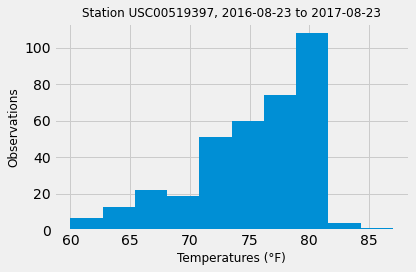

In [84]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_act_station = measure_p12mth.loc[measure_p12mth['station'] == 'USC00519397']
most_act_station.hist('tobs')
plt.title('Station USC00519397, 2016-08-23 to 2017-08-23', fontsize='12')
plt.xlabel('Temperatures (°F)', fontsize='12')
plt.ylabel('Observations', fontsize='12')

plt.tight_layout()
plt.savefig("Images/Station_USC00519397.png")
plt.show()

## Bonus Challenge Assignment

In [39]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [57]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

trip_temps = calc_temps('2017-02-28', '2017-03-05') 
print(trip_temps)

[(64.0, 72.02777777777777, 78.0)]


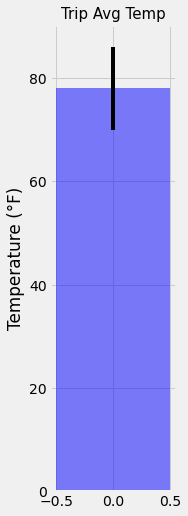

In [103]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = trip_temps[0][0]
tmax = trip_temps[0][1]
tavg = trip_temps[0][2]

y_err = tmax-tmin

plt.figure(figsize=(2,8))
plt.bar(0, tavg, yerr=y_err, align="center", width=1, color="b", alpha=0.5)
plt.ylim=(0,50)
plt.ylabel('Temperature (°F)')
plt.title('Trip Avg Temp', fontsize=15)
plt.savefig("Images/Avg_Trip_Temperature.png")
plt.show()

In [126]:
station_df = pd.read_sql("SELECT * FROM station", engine)
station_df.dropna(how='any', inplace=True)
station_df

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [137]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = measurement_df.loc[(measurement_df['date'] >= '2017-02-28') & 
                              (measurement_df['date'] <= '2017-03-05')]

rainfall_df = rainfall[['station','prcp']]

station_cosl = pd.merge(rainfall_df, station_df, how='left', on='station')


# station_cosl
# rainfall_df.sum(level=0)

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
